In [1]:
import sys, os
print(sys.executable)
print(os.getcwd())

C:\Users\chenr\miniforge3\envs\astropy\python.exe
C:\Users\chenr\OneDrive\Desktop\phys-134-proj


In [2]:
rootfolder=os.getcwd().replace('\\','/')
print(rootfolder)

C:/Users/chenr/OneDrive/Desktop/phys-134-proj


In [3]:
os.chdir(f"{rootfolder}/lco_data-20251202-36")
os.getcwd()

'C:\\Users\\chenr\\OneDrive\\Desktop\\phys-134-proj\\lco_data-20251202-36'

In [4]:
# we need the RA/DEC data from each observation and translate it to pixel coordinates.
import pickle
#load from pickle
with open('merged_data_with_refstarfluxes.pkl', 'rb') as f:
    merged_data = pickle.load(f)
#recall that the keys are the valid observations

Set OBSGEO-B to    28.300308 from OBSGEO-[XYZ].
Set OBSGEO-H to     2386.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -30.167703 from OBSGEO-[XYZ].
Set OBSGEO-H to     2197.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    30.680041 from OBSGEO-[XYZ].
Set OBSGEO-H to     2026.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    20.706969 from OBSGEO-[XYZ].
Set OBSGEO-H to     3033.997 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    28.300308 from OBSGEO-[XYZ].
Set OBSGEO-H to     2386.995 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.380633 from OBSGEO-[XYZ].
Set OBSGEO-H to     1756.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272819 from OBSGEO-[XYZ].
Set OBSGEO-H to     1126.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


To systematically locate the asteroid, it would be optimal to use the exact timestamp of the observation and query the horizons API with the observatory coordinates to obtain the ephermeris data at that time and location.

The sky coordinates then should be translated to XY image coordinates by help of the WCS object

In [11]:
# the indices also encode time and coordinate information
# 2025-11-25-h02-m00-s14-ms936-tfn.fits

# COJ - Siding Spring Observatory
coj = "Q63" # is an observatory code
# 31° 16′ 23.88″S
# 149° 4′ 15.6″E

# CPT - (Sutherland) South African Astronomical Observatory
cpt = "K91"
# 32° 22′ 48″S
# 20° 48′ 36″E

#TFN - Teide (Tenerife) Observatory
tfn = "Z31"
# 28º 18′ 00″N
# 16° 30′ 35″W

#LSC - Cerro Tololo Inter-American Observatory
lsc = "W85"
# 30° 10′ 2.64″S
# 70° 48′ 17.28″W

#ELP - McDonald Observatory
elp = "V37"
# 30° 40′ 12″N
# 104° 1′ 12″W

#OGG - Haleakala Observatory
ogg = "T04"
# 20° 42′ 27″N
# 156° 15′ 21.6″W


defining HTTP request

In [12]:
# 16 psyche SPIKID
SPKID = 20000016

API_URL = "https://ssd.jpl.nasa.gov/api/horizons.api"

# format : "json" (output format)
# COMMAND : f"DES={SPKID}" (target body)
# OBJ_DATA : "NO"
# MAKE_EPHEM : "YES"
# EPHEM_TYPE : "OBSERVER"

# CENTER : f"coord@{observatory_code}" (observatory location)
# TIME_DIGITS: "FRACSEC"
# TIME_TYPE: "UT"
# TLIST: # is a list of (we chose CAL so) format is ex '2033-Jan-17 12:10:25.1'
# TLIST_TYPE: "CAL"
# APPARENT: "REFRACTED"

params_format = {
    "format": "text",
    "COMMAND": f"'DES={SPKID};'",
    "OBJ_DATA": "NO",
    "MAKE_EPHEM": "YES",
    "CENTER": "", # to be filled with observatory code
    "TIME_DIGITS": "FRACSEC",
    "TIME_TYPE": "UT",
    "TLIST": "", # to be filled with observation time
    "TLIST_TYPE": "CAL"
    # ,"APPARENT": "REFRACTED"
}

In [13]:

# indices
#is an array of strings in the format
# 2025-11-25-h02-m00-s14-ms936-tfn.fits
# <year>-<month>-<day>-h<hour>-m<minute>-s<second>-ms<millisecond>-<observatory>.fits

for filename in merged_data.keys():
    parts = filename.split('-')
    year = parts[0]
    month = parts[1]
    day = parts[2]
    hour = parts[3][1:]  # remove 'h'
    minute = parts[4][1:]  # remove 'm'
    second = parts[5][1:]  # remove 's'
    millisecond = parts[6][2:]  # remove 'ms'
    observatory_str = parts[7].split('.')[0]  # remove '.fits'
    
    # Map observatory string to code
    observatory_code = {
        'coj': coj,
        'cpt': cpt,
        'tfn': tfn,
        'lsc': lsc,
        'elp': elp,
        'ogg': ogg
    }.get(observatory_str, None)
    
    if observatory_code is None:
        raise ValueError(f"Unknown observatory string: {observatory_str}")
    
    # Format month to three-letter abbreviation
    month_abbr = {
        '01': 'Jan', '02': 'Feb', '03': 'Mar', '04': 'Apr',
        '05': 'May', '06': 'Jun', '07': 'Jul', '08': 'Aug',
        '09': 'Sep', '10': 'Oct', '11': 'Nov', '12': 'Dec'
    }[month]
    
    # Construct datetime string
    
    datetime_str = f"{year}-{month_abbr}-{day} {hour}:{minute}:{second}.{millisecond}"
    
    merged_data[filename]['datetime_str'] = datetime_str
    merged_data[filename]['observatory_code'] = observatory_code


In [9]:
merged_data[list(merged_data.keys())[0]]

{'icrs': {'ra': array([77.96901145, 78.00383066, 77.98107419, 78.08611895, 77.67491618,
         77.75851002, 77.83228109, 77.64550192, 77.7778916 , 77.79665041,
         77.74453099, 78.02132324, 78.03735253, 77.99115373, 77.826763  ]),
  'dec': array([18.03399294, 18.03051053, 18.11159006, 18.13817795, 18.08610803,
         18.11167927, 18.3110055 , 18.29675712, 18.31631118, 18.41226387,
         18.41350691, 18.29639713, 18.32767694, 18.33238649, 18.41757886])},
 'image': {'x': array([ 674.51008,  515.45897,  618.67282,  137.7245 , 2021.3085 ,
         1637.122  , 1299.9491 , 2154.6617 , 1548.8365 , 1462.3786 ,
         1700.4093 ,  435.45068,  361.83888,  573.49969, 1324.5271 ]),
  'y': array([ 325.71172,  308.99125,  699.70433,  826.61105,  578.00791,
          700.31366, 1661.0504 , 1593.8816 , 1686.4079 , 2149.6571 ,
         2155.6244 , 1590.5307 , 1741.6414 , 1763.3525 , 2172.8186 ])},
 'nddata': NDData([[ 4.7827606 ,  0.3642283 , -0.9027024 , ...,  0.6471738 ,
           0.69

In [17]:
import requests
from astropy.coordinates import SkyCoord
from astropy import wcs

for idx, filename in enumerate(merged_data.keys()):
    time = merged_data[filename]['datetime_str']
    observatory_code = merged_data[filename]['observatory_code']
    
    params = params_format.copy()
    params['TLIST'] = f"'{time}'"
    params['CENTER'] = observatory_code

    response = requests.get(API_URL, params=params)
    resp= response.text
    p = resp.split('$$SOE')[1].split('$$EOE')[0].strip()
    data_line = p.split('\n')[0]
    data_parts = data_line.split()

    ra_hr = int(data_parts[2])
    ra_min = int(data_parts[3])
    ra_sec = float(data_parts[4])
    dec_deg = int(data_parts[5])
    dec_min = int(data_parts[6])
    dec_sec = float(data_parts[7])

    skycoord = SkyCoord(f"{ra_hr}h{ra_min}m{ra_sec}s", f"{dec_deg}d{dec_min}m{dec_sec}s", frame='icrs')

    w = merged_data[filename]['nddata'].wcs
    x, y = wcs.utils.skycoord_to_pixel(skycoord, w, 0, 'all') # 0 based indexing (for numpy use), 1 based for FITS

    print(f"File {idx+1}/{len(merged_data.keys())}: {filename} -> Pixel Coordinates: x={x}, y={y}")
    
    merged_data[filename]['pixel_coords'] = (float(x), float(y))

File 1/35: 2025-11-25-h02-m00-s14-ms936-tfn.fits -> Pixel Coordinates: x=51.463159313362894, y=1306.5623972735461
File 2/35: 2025-11-25-h05-m00-s13-ms688-lsc.fits -> Pixel Coordinates: x=163.32838677069026, y=1298.0649641231462
File 3/35: 2025-11-25-h05-m36-s42-ms454-lsc.fits -> Pixel Coordinates: x=193.39110815730476, y=1302.7177748840788
File 4/35: 2025-11-25-h06-m06-s14-ms909-lsc.fits -> Pixel Coordinates: x=202.5728591739104, y=1288.3294670393786
File 5/35: 2025-11-25-h07-m45-s12-ms840-elp.fits -> Pixel Coordinates: x=243.60085281825695, y=1311.1101533866708
File 6/35: 2025-11-25-h08-m30-s09-ms718-elp.fits -> Pixel Coordinates: x=311.2709350506832, y=1293.1047093565235
File 7/35: 2025-11-25-h09-m06-s12-ms841-elp.fits -> Pixel Coordinates: x=277.88915326285087, y=1329.2067636523307
File 8/35: 2025-11-25-h10-m06-s14-ms367-elp.fits -> Pixel Coordinates: x=311.53950388553176, y=1319.9104347661041
File 9/35: 2025-11-25-h11-m06-s18-ms072-elp.fits -> Pixel Coordinates: x=394.2636847154460

In [19]:
merged_data[list(merged_data.keys())[1]]

{'icrs': {'ra': array([77.96901145, 78.00383066, 77.98107419, 78.08611895, 77.67491618,
         77.75851002, 77.83228109, 77.64550192, 77.7778916 , 77.79665041,
         77.74453099, 78.02132324, 78.03735253, 77.99115373, 77.826763  ]),
  'dec': array([18.03399294, 18.03051053, 18.11159006, 18.13817795, 18.08610803,
         18.11167927, 18.3110055 , 18.29675712, 18.31631118, 18.41226387,
         18.41350691, 18.29639713, 18.32767694, 18.33238649, 18.41757886])},
 'image': {'x': array([ 669.8357 ,  508.78492,  612.81842,  128.88614, 2024.0029 ,
         1637.4491 , 1296.4271 , 2156.8919 , 1547.0131 , 1459.3625 ,
         1698.9329 ,  427.27715,  353.71118,  565.47001, 1320.8434 ]),
  'y': array([ 318.54021,  301.40698,  694.58834,  821.14283,  575.56554,
          696.37803, 1662.1788 , 1595.7014 , 1688.683  , 2153.2121 ,
         2159.3934 , 1590.2609 , 1741.3498 , 1764.1286 , 2176.0201 ])},
 'nddata': NDData([[ 2.8161645e+00,  1.7441673e+00,  4.2024298e+00, ...,
          -1.191695

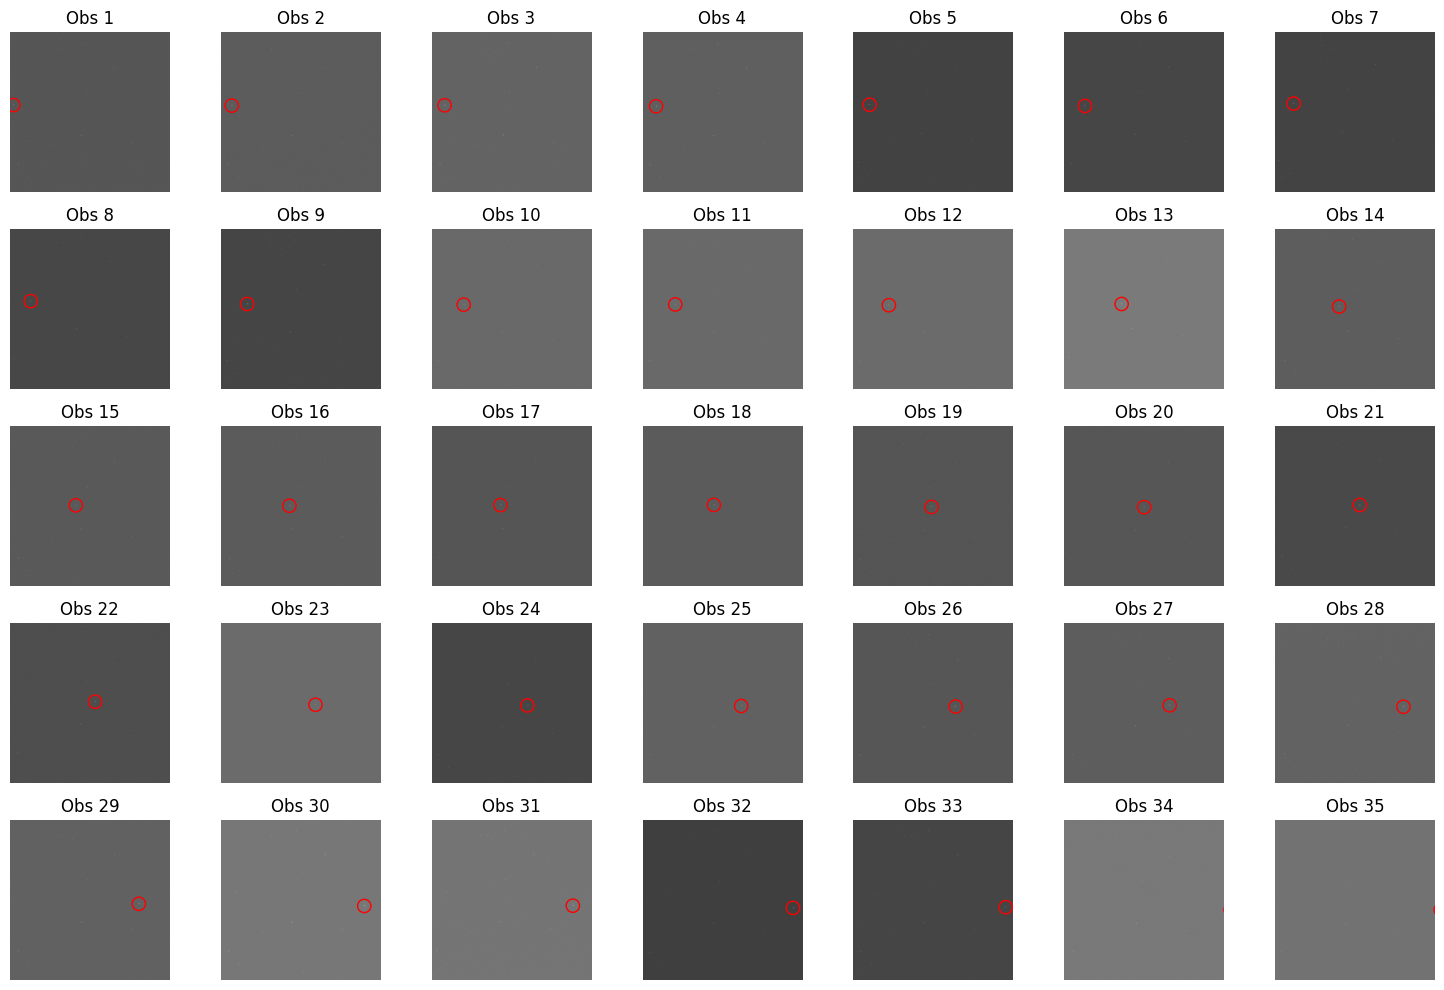

In [23]:

# tile plot images with asteroid positions marked
import matplotlib.pyplot as plt
import math
import numpy as np

def imageprocessing(arr, a=1000, contrast=1, bias=0.5):
    min_im, max_im = np.min(arr), np.max(arr)
    norm = (arr - min_im) / (max_im - min_im)
    log = np.log(1 + a*norm) / np.log(1+a)
    final_data = (log- 0.5) * contrast + bias
    final_data = np.clip(final_data, 0, 1)
    return final_data

# 5 rows 7 cols
fig, axs = plt.subplots(5, 7, figsize=(15, 10))
axs = axs.flatten()
for idx, filename in enumerate(merged_data.keys()):
    image_data = merged_data[filename]['nddata'].data
    x, y = merged_data[filename]['pixel_coords']
    
    ax = axs[idx]
    ax.imshow(imageprocessing(image_data), cmap='gray', origin='lower')
    # ax.plot(x, y, 'ro', markersize=5)  # mark asteroid position
    #draw a large and thin circle on the position
    circle = plt.Circle((x, y), radius=100, color='red', fill=False, linewidth=1)
    ax.add_patch(circle)
    ax.set_title(f"Obs {idx+1}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [25]:
#we'll need to toss out the last two observations
del merged_data[list(merged_data.keys())[-1]]
del merged_data[list(merged_data.keys())[-1]]

In [26]:
len(merged_data)

33